In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import copy
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [186]:
df = pd.read_csv("SeoulBikeData.csv").drop(["Functioning Day","Date"],axis=1)
df.head()

Rented Bike Count  Hour  Temperature  Humidity  Wind speed  Visibility  \
0                254     0         -5.2        37         2.2        2000   
1                204     1         -5.5        38         0.8        2000   
2                173     2         -6.0        39         1.0        2000   
3                107     3         -6.2        40         0.9        2000   
4                 78     4         -6.0        36         2.3        2000   

   Dew point temperature  Solar Radiation  Rainfall  Snowfall (cm) Seasons  \
0                  -17.6              0.0       0.0            0.0  Winter   
1                  -17.6              0.0       0.0            0.0  Winter   
2                  -17.7              0.0       0.0            0.0  Winter   
3                  -17.6              0.0       0.0            0.0  Winter   
4                  -18.6              0.0       0.0            0.0  Winter   

      Holiday  
0  No Holiday  
1  No Holiday  
2  No Holiday  
3  No Holiday  
4  No Holiday

In [187]:
df = df[df["Hour"]==12]
df = df.drop(["Hour"],axis=1)

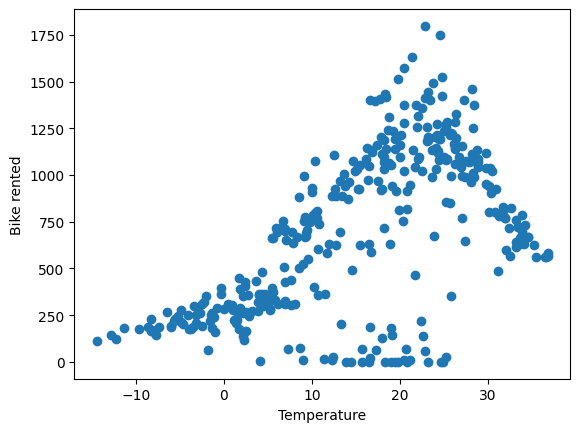

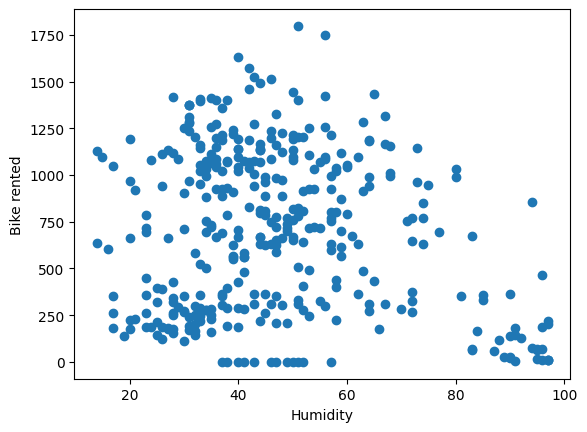

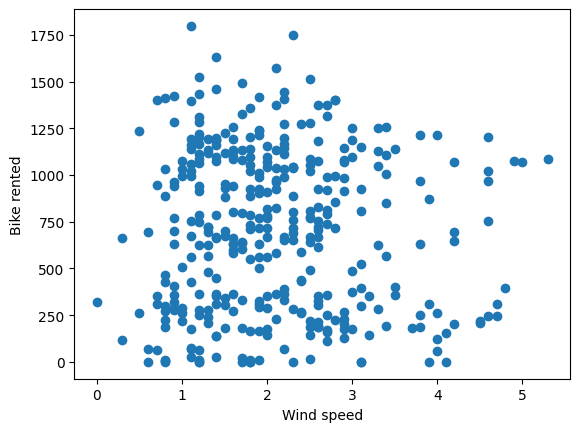

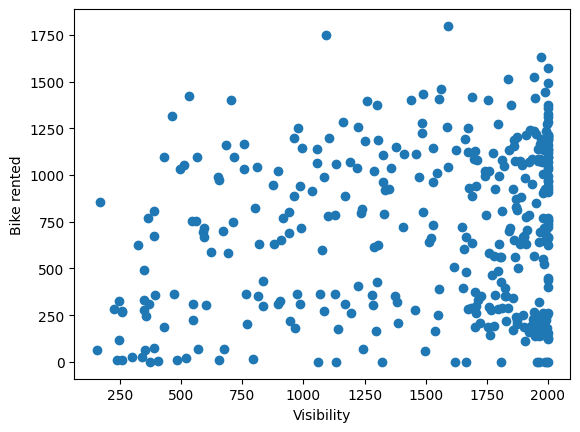

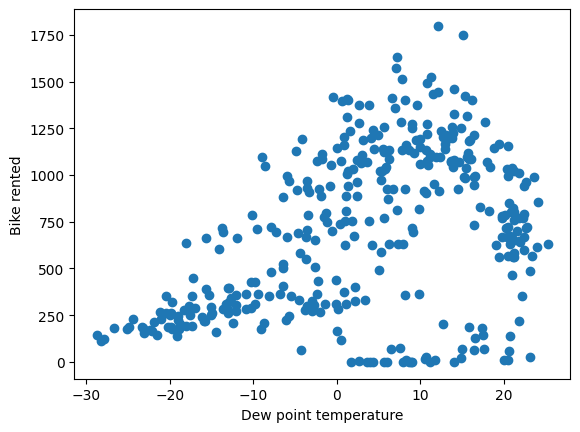

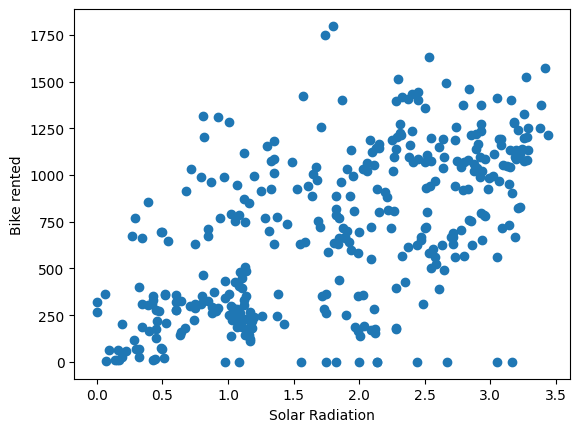

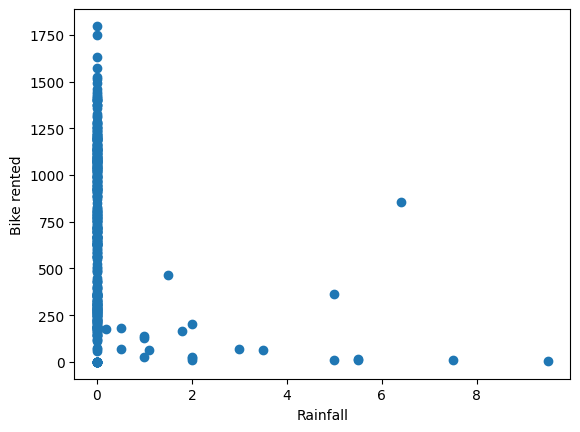

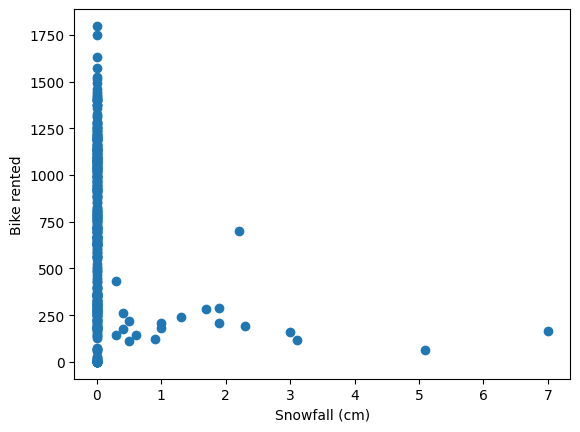

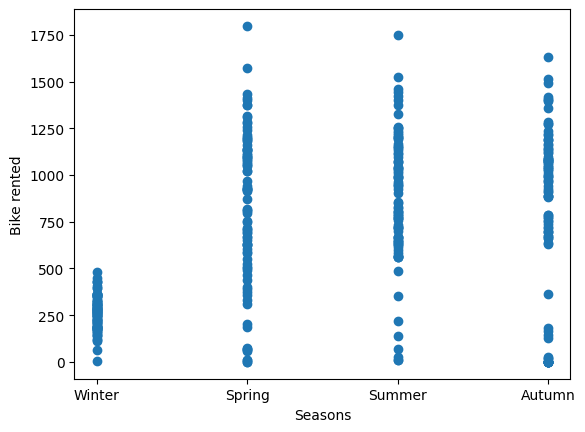

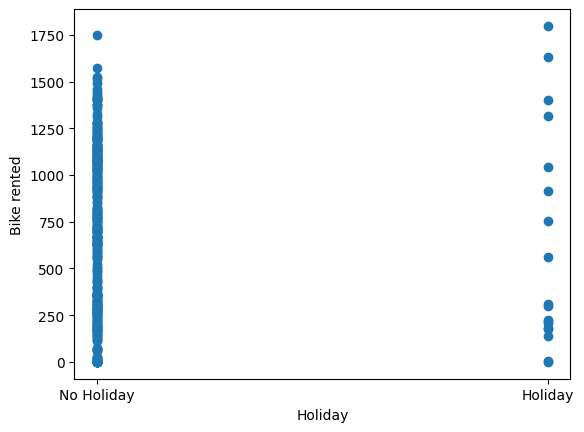

In [188]:
for label in df.columns[1:]:
    plt.scatter(df[label],df["Rented Bike Count"])
    plt.xlabel(label)
    plt.ylabel("Bike rented")
    plt.show()

In [189]:
df = df.drop(["Wind speed","Visibility","Seasons","Holiday"],axis=1)

In [190]:
df.head()

Rented Bike Count  Temperature  Humidity  Dew point temperature  \
12                 449          1.7        23                  -17.2   
36                 479          4.3        41                   -7.8   
60                 333          5.8        85                    3.4   
84                 393         -0.3        38                  -12.9   
108                321         -2.3        25                  -19.7   

     Solar Radiation  Rainfall  Snowfall (cm)  
12              1.11       0.0            0.0  
36              1.09       0.0            0.0  
60              0.43       0.0            0.0  
84              1.11       0.0            0.0  
108             0.00       0.0            0.0

In [323]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)),int(0.8*len(df))])

/Users/pavan/Code/ml/ml/ml_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [324]:
def get_xy(dataframe,y_label,x_label=None):
    dataframe = copy.deepcopy(dataframe)
    if x_label is None:
        x = dataframe[[c for c in dataframe.columns if c!=y_label]].values
    else :
        if len(x_label)==1:
            x = dataframe[x_label[0]].values.reshape(-1,1)
        else:
            x = dataframe[x_label].values
    y = dataframe[y_label].values.reshape(-1,1)
    data = np.hstack((x,y))
    return data, x, y;
    

In [325]:
 _,x_train_temp, y_train_temp = get_xy(train, y_label="Rented Bike Count",x_label=["Temperature"])
 _,x_valid_temp, y_valid_temp = get_xy(valid, "Rented Bike Count", x_label=["Temperature"])
_,x_test_temp, y_test_temp = get_xy(test, "Rented Bike Count", x_label=["Temperature"])


In [326]:
reg_temp = LinearRegression()
reg_temp.fit(x_train_temp,y_train_temp)


LinearRegression()

In [327]:
print(reg_temp.coef_, reg_temp.intercept_)

[[23.39407525]] [345.33417537]


In [328]:
 _,x_train, y_train = get_xy(train, y_label="Rented Bike Count",x_label=df.columns[1:])
 _,x_valid, y_valid = get_xy(valid, "Rented Bike Count",x_label=df.columns[1:])
_,x_test, y_test = get_xy(test, "Rented Bike Count",x_label=df.columns[1:])


In [329]:
all_reg  = LinearRegression()
all_reg.fit(x_train,y_train)

LinearRegression()

In [330]:
print(all_reg.score(x_test,y_test))


0.4510295689282212


# Regression with neural network

In [331]:
temp_normalizer = keras.layers.Normalization(input_shape=(1,),axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))

/Users/pavan/Code/ml/ml/ml_env/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [332]:
nn_model = keras.Sequential([
    temp_normalizer,
    layers.Dense(32,activation='relu'),
    layers.Dense(32,activation='relu'),
    layers.Dense(32,activation='relu'),
    layers.Dense(1,activation='relu')
])

In [333]:
nn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),loss = 'mean_squared_error')

In [334]:
history = nn_model.fit(
    x_train_temp,y_train_temp,
    verbose=0,
    validation_data=(x_valid_temp,y_valid_temp),
    epochs=100
)

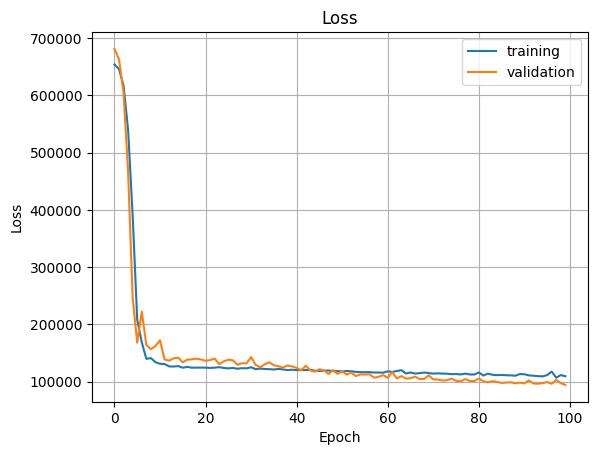

In [335]:
plt.plot(history.history['loss'],label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step


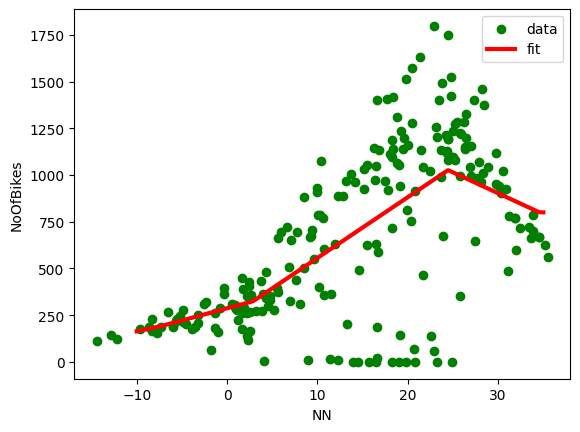

In [337]:
plt.scatter(x_train_temp,y_train_temp,label='data',color='green')
line = tf.linspace(-10,35,1000)
plt.plot(line,nn_model.predict(np.array(line).reshape(-1,1)),label='fit',color='red', linewidth=3)
plt.xlabel("NN")
plt.ylabel("NoOfBikes")
plt.legend()
plt.show()

In [360]:
normalizer = keras.layers.Normalization(input_shape=(6,),axis=None)
normalizer.adapt(x_train)

In [361]:
nn_model_all = keras.Sequential([
    normalizer,
    layers.Dense(32,activation='relu'),
    layers.Dense(32,activation='relu'),
    layers.Dense(32,activation='relu'),
        layers.Dense(32,activation='relu'),
    layers.Dense(1,activation='relu')
])
nn_model_all.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),loss='mean_squared_error')

In [362]:
history = nn_model_all.fit(
    x_train,y_train,
    epochs=500,validation_data=(x_valid,y_valid),verbose=0
)

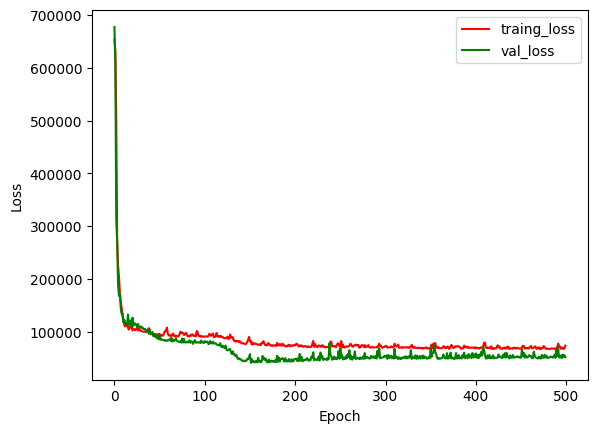

In [363]:
plt.plot(history.history['loss'],label='traing_loss',color='red')
plt.plot(history.history['val_loss'],label='val_loss',color='green')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [364]:
y_pred_lr = all_reg.predict(x_test)
y_pred_nn = nn_model_all.predict(x_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [365]:
def MSE(y_pred,y_real):
    return (np.square(y_pred-y_real)).mean()

In [366]:
MSE(y_pred_lr,y_test)


89795.77413786601

In [367]:
MSE(y_pred_nn,y_test)

62549.89673456164

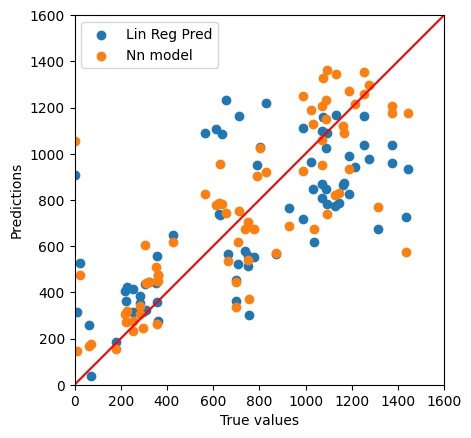

In [370]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test,y_pred_lr,label='Lin Reg Pred')
plt.scatter(y_test,y_pred_nn,label='Nn model')
plt.xlabel("True values")
plt.ylabel("Predictions")
lims =[0,1600]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims,c='red')
plt.legend()
plt.show()